In [61]:
# Load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import operator
from itertools import chain
import pickle
from scipy.stats import spearmanr

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [62]:
# Set more columns viewable
pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows', 200)

In [63]:
#Load dataset and convert data points to same type
train = pd.read_csv('train.csv')
train.info()
train.iloc[:,1:] = train.iloc[:,1:].astype('int')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Columns: 4993 entries, ID to 9fc776466
dtypes: float64(1845), int64(3147), object(1)
memory usage: 169.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Columns: 4993 entries, ID to 9fc776466
dtypes: int32(4992), object(1)
memory usage: 84.9+ MB


In [64]:
# pick = [df2,df_new,new_cols,sorted_train,df,trans_train,test]

In [65]:
# with open('satander.pickle','rb') as f:
#     pickle_ls = pickle.load(f)

# df2 = pickle_ls[0]
# df_new = pickle_ls[1]
# new_cols = pickle_ls[2]
# sorted_train = pickle_ls[3]
# df = pickle_ls[4]
# trans_train = pickle_ls[5]

In [66]:
train.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,dc5a8f1d8,11d86fa6a,77c9823f2,8d6c2a0b2,4681de4fd,adf119b9a,cff75dd09,96f83a237,b8a716ebf,6c7a4567c,4fcfd2b4d,f3b9c0b95,71cebf11c,d966ac62c,68b647452,c88d108c9,ff7b471cd,d5308d8bc,0d866c3d7,bc3f77679,bd8f989f1,0eff5bf95,22ed6dba3,92b13ebba,c330f1a67,233c7c17c,2cb4d123e,eeac16933,87ffda550,822e49b95,316b978cd,d04e16aed,5d5c5ce6d,ec863cb52,11ad148bd,ea18d720e,408d86ce9,69d8b4020,b0868a049,80b14398e,ecdef52b2,c36bcacc5,151d318cd,ab0cddb90,2d6bd8275,dfdf4b580,c87722678,a8c320153,7df8788e8,a04684f1f,fa977f17b,feed9d437,645b47cde,7298ca1ef,d80abf8bc,654dd8a3b,7fc39583c,8c94b6675,e421c414e,5b91580ee,964335fdf,5a86cabd0,6cb207ac9,c1bc828da,e90ed19da,c4d38135f,968b01ca3,26b423c42,0656586a4,b4ced4b7a,0b8e10df6,603e85eb7,605728195,4e8196700,f115e74c0,9ca0eee11,472cd130b,ee7e4581d,3e0e55648,a939664aa,b0f5ed414,a72e0bf30,e662f1672,54b1c1bc0,ec1425047,78a879b5d,bd550871c,828b327a6,3268914c7,...,e369704a1,7df9efba5,f5723deba,7fd35c77a,9d9e518a3,99258443a,1d81e197a,831a9e087,de471ea65,8781e4b91,dc5ba677f,df3ac443c,79203fbab,f1ab19e7a,300398f1c,6eefca12e,22bf44001,19915a6d3,20a325694,8afae1db8,c283d4609,11114a47a,b961b0d59,103b8a033,43d70cc4d,09184c121,08c089775,572d36d31,1de239e78,d7568383a,8d7bfb911,5964f1856,6c7bf200b,b3058e9ba,108fe14ef,dcfcddf16,5fad07863,b904b8345,408021ef8,ef30f6be5,e29d22b59,a19b05919,e849e3ae0,05f11f48f,49f11e712,c959d372a,b625fe55a,f642213a6,6df033973,1834f29f5,31e434a58,e431708ff,fb42abc0d,88263a031,ab7764ead,a380d5301,46ee7f2c8,2e1287e41,23310aa6f,9dc52515a,969caa87a,00302fe51,1189ee335,ca04a07ca,f6f15ffa5,841704460,ea5ed6ff7,b1bb8eac3,8132d18b8,c24ea6548,cdfc2b069,2a879b4f7,6b119d8ce,98dea9e42,9f2471031,88458cb21,f40da20f4,7ad6b38bd,c901e7df1,8f55955dc,85dcc913d,5ca0b9b0c,eab8abf7a,8d8bffbae,2a1f6c7f9,9437d8b64,5831f4c76,2e84e09c5,d45fd5508,a165f5761,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1300000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1266666,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1100000,0,0,0,0,0,14800000,0,1200000,0,0,0,0,0,0,0,4000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,000fbd867,600000,0,0,0,0,0,0,0,0,2200000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0027d6b71,10000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0028cbf45,2000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,002a68644,14400000,0,0,0,0,0,0,0,0,2000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [67]:
# Dataframe has no null values
np.unique(train.isnull().values)

array([False])

Text(0.5,1,'Standard Deviations of Columns')

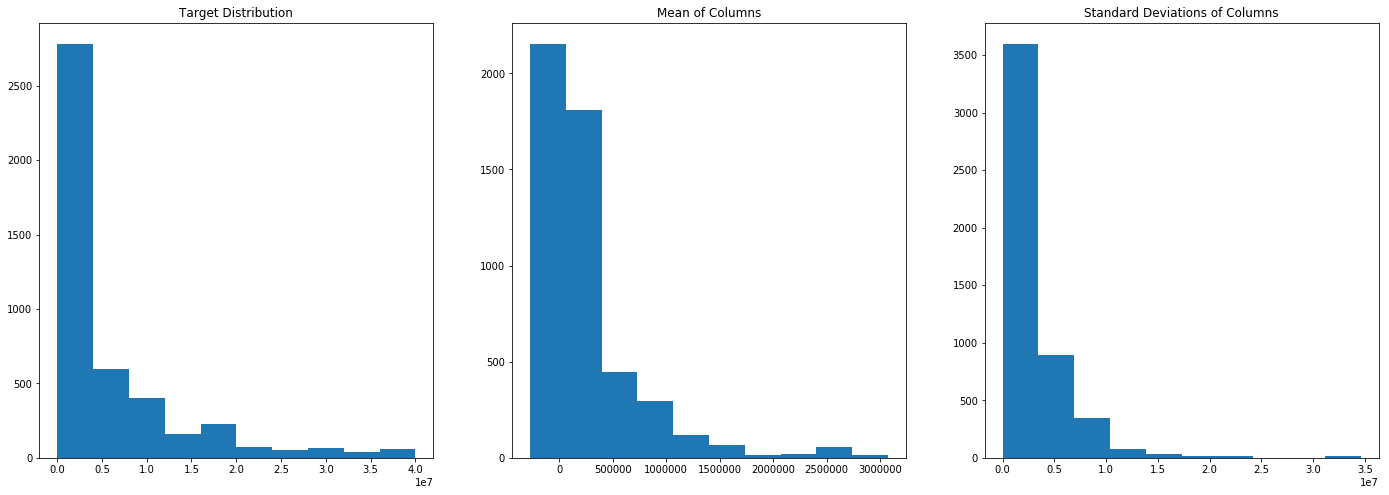

In [68]:
fig, ax = plt.subplots(1, 3,figsize = (24,8))

ax[0].hist(train['target'])
ax[0].set_title('Target Distribution')
    
ax[1].hist(train.iloc[:,2:].apply(lambda x: np.mean(x)))
ax[1].set_title('Mean of Columns')

ax[2].hist(train.iloc[:,2:].apply(lambda x: np.std(x)) )
ax[2].set_title('Standard Deviations of Columns')

Some of the columns have a standard deviation of 0 so they only contain a single repeating value. So we drop them

In [69]:
drop_cols = []

def no_unique(df):
    for col in df:

        if len(df[col].unique()) == 1:
            df.drop(col, axis = 1, inplace = True)
            drop_cols.append(col)
    print("{} columns dropped".format(len(drop_cols)))
no_unique(train)

256 columns dropped


## Drawing inspiration from [Giba](https://www.kaggle.com/titericz/the-property-by-giba)

In [70]:
cols = [
    "f190486d6","58e2e02e6","eeb9cd3aa","9fd594eec","6eef030c1","15ace8c9f",
    "fb0f5dbfe","58e056e12","20aa07010","024c577b9","d6bb78916",
    "b43a7cfd5","58232a6fb"
]
rows = np.array([2072,3493,379,2972,2367,4415,2791,3980,194,1190,3517,811,4444])-1


## Train is a time series data set with target being an n-2 lag with f190486d6 being the last known timestamp

In [71]:
sort_train = train.loc[rows,cols]
train2 = train.iloc[rows,2:]

In [72]:
pd.concat([train.loc[sort_train.index,'target'],sort_train], axis = 1)

,target,f190486d6,58e2e02e6,eeb9cd3aa,9fd594eec,6eef030c1,15ace8c9f,fb0f5dbfe,58e056e12,20aa07010,024c577b9,d6bb78916,b43a7cfd5,58232a6fb
2071,3513333,0,1477600,1586888,75000,3147200,466461,1600000,0,440000,3076666,550000,247166,296444
3492,160000,310000,0,1477600,1586888,75000,3147200,466461,1600000,0,440000,3076666,550000,247166
378,2352551,3513333,310000,0,1477600,1586888,75000,3147200,466461,1600000,0,440000,3076666,550000
2971,280000,160000,3513333,310000,0,1477600,1586888,75000,3147200,466461,1600000,0,440000,3076666
2366,5450500,2352551,160000,3513333,310000,0,1477600,1586888,75000,3147200,466461,1600000,0,440000
4414,1359000,280000,2352551,160000,3513333,310000,0,1477600,1586888,75000,3147200,466461,1600000,0
2790,60000,5450500,280000,2352551,160000,3513333,310000,0,1477600,1586888,75000,3147200,466461,1600000
3979,12000000,1359000,5450500,280000,2352551,160000,3513333,310000,0,1477600,1586888,75000,3147200,466461
193,500000,60000,1359000,5450500,280000,2352551,160000,3513333,310000,0,1477600,1586888,75000,3147200
1189,1878571,12000000,60000,1359000,5450500,280000,2352551,160000,3513333,310000,0,1477600,1586888,75000


In [73]:
new_cols = cols 

In [74]:
def thresh_sort(sort_df, df, direction = 'tail',thresh = 0.7):
    count = 0
    loops = 0
    finds = {}
    new_rows = sort_df.index
    # Adds columns to left side
    if direction == 'head':
        head = sort_df.columns[0] 
        while True:
        
            for col in df:

                if col in sort_df:
                    continue

                x = sort_df.iloc[1+loops:,0]
                y = df.loc[new_rows, col].iloc[:-1-loops]

                compare = len([i for i,j in zip(x,y) if i == j])
                threshold = compare / len(sort_df)
                
                if threshold > thresh:
                    if head in finds:
                        finds[head][col] = threshold
                        
                    else:
                        finds[head] = {col: threshold}
                        
            try:
                if len(finds[head]) > 0 :
                    new_col = max(finds[head].items(), key=operator.itemgetter(1))[0]
                    sort_df = pd.concat([ df.loc[new_rows, new_col] , sort_df], axis = 1)
                    print("Found column: {} with lag {} with threshold {}".format(new_col,loops+1,finds[head][new_col]))
                    head = sort_df.columns[0] 
                    count += 1
            except KeyError:        
                pass
            
            if count == 0 and loops == 5:
                break
            # At least 1 match 
            elif count > 0:
                count = 0
                loops = 0
            # No match
            else: 
                count = 0
                loops += 1
    if direction == 'tail':
        tail = sort_df.columns[-1] 
        while True:
        
            for col in df:

                if col in sort_df:
                    continue

                x = sort_df.iloc[:-1-loops, -1]
                y = df.loc[new_rows, col].iloc[1+loops:]

                compare = len([i for i,j in zip(x,y) if i == j])
                threshold = compare / len(sort_df)
                
                if threshold > thresh:
                    if tail in finds:
                        finds[tail][col] = threshold
                        
                    else:
                        finds[tail] = {col: threshold}
                        
            try:
                if len(finds[tail]) > 0 :
                    new_col = max(finds[tail].items(), key=operator.itemgetter(1))[0]
                    sort_df = pd.concat([sort_df, df.loc[new_rows, new_col]], axis = 1)
                    print("Found column: {} with lag {} with threshold {}".format(new_col,loops+1,finds[tail][new_col]))
                    tail = sort_df.columns[-1] 
                    count += 1
            except KeyError:        
                pass
            
            if count == 0 and loops == 5:
                break
            # At least 1 match 
            elif count > 0:
                count = 0
                loops = 0
            # No match
            else: 
                count = 0
                loops += 1
                
   
    return sort_df, finds

# We can expand upon the dataframe by looking for other columns that are lagged from either end of the dataframe

In [87]:
sort_train

,f190486d6,58e2e02e6,eeb9cd3aa,9fd594eec,6eef030c1,15ace8c9f,fb0f5dbfe,58e056e12,20aa07010,024c577b9,d6bb78916,b43a7cfd5,58232a6fb
2071,0,1477600,1586888,75000,3147200,466461,1600000,0,440000,3076666,550000,247166,296444
3492,310000,0,1477600,1586888,75000,3147200,466461,1600000,0,440000,3076666,550000,247166
378,3513333,310000,0,1477600,1586888,75000,3147200,466461,1600000,0,440000,3076666,550000
2971,160000,3513333,310000,0,1477600,1586888,75000,3147200,466461,1600000,0,440000,3076666
2366,2352551,160000,3513333,310000,0,1477600,1586888,75000,3147200,466461,1600000,0,440000
4414,280000,2352551,160000,3513333,310000,0,1477600,1586888,75000,3147200,466461,1600000,0
2790,5450500,280000,2352551,160000,3513333,310000,0,1477600,1586888,75000,3147200,466461,1600000
3979,1359000,5450500,280000,2352551,160000,3513333,310000,0,1477600,1586888,75000,3147200,466461
193,60000,1359000,5450500,280000,2352551,160000,3513333,310000,0,1477600,1586888,75000,3147200
1189,12000000,60000,1359000,5450500,280000,2352551,160000,3513333,310000,0,1477600,1586888,75000


In [76]:
sorted_train, finds = thresh_sort(sort_train,train2)

Found column: 1702b5bf0 with lag 1 with threshold 0.9230769230769231
Found column: 324921c7b with lag 1 with threshold 0.9230769230769231
Found column: 62e59a501 with lag 1 with threshold 0.9230769230769231
Found column: 2ec5b290f with lag 1 with threshold 0.9230769230769231
Found column: 241f0f867 with lag 1 with threshold 0.9230769230769231
Found column: fb49e4212 with lag 1 with threshold 0.9230769230769231
Found column: 66ace2992 with lag 1 with threshold 0.9230769230769231
Found column: f74e8f13d with lag 1 with threshold 0.9230769230769231
Found column: 5c6487af1 with lag 1 with threshold 0.9230769230769231
Found column: 963a49cdc with lag 1 with threshold 0.9230769230769231
Found column: 26fc93eb7 with lag 1 with threshold 0.9230769230769231
Found column: 1931ccfdd with lag 1 with threshold 0.9230769230769231
Found column: 703885424 with lag 1 with threshold 0.9230769230769231
Found column: 70feb1494 with lag 1 with threshold 0.9230769230769231
Found column: 491b9ee45 with lag 1

In [77]:
sorted_train

,f190486d6,58e2e02e6,eeb9cd3aa,9fd594eec,6eef030c1,15ace8c9f,fb0f5dbfe,58e056e12,20aa07010,024c577b9,d6bb78916,b43a7cfd5,58232a6fb,1702b5bf0,324921c7b,62e59a501,2ec5b290f,241f0f867,fb49e4212,66ace2992,f74e8f13d,5c6487af1,963a49cdc,26fc93eb7,1931ccfdd,703885424,70feb1494,491b9ee45,23310aa6f,0572565c2,6619d81fc,fc99f9426,1db387535,0ff32eb98,91f701ba2,adb64ff71,c5a231d81,e176a204a,190db8488,c47340d97
2071,0,1477600,1586888,75000,3147200,466461,1600000,0,440000,3076666,550000,247166,296444,834800,115636,540000,1015000,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411
3492,310000,0,1477600,1586888,75000,3147200,466461,1600000,0,440000,3076666,550000,247166,296444,834800,115636,540000,1015000,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411
378,3513333,310000,0,1477600,1586888,75000,3147200,466461,1600000,0,440000,3076666,550000,247166,296444,834800,115636,540000,1015000,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411
2971,160000,3513333,310000,0,1477600,1586888,75000,3147200,466461,1600000,0,440000,3076666,550000,247166,296444,834800,115636,540000,1015000,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411
2366,2352551,160000,3513333,310000,0,1477600,1586888,75000,3147200,466461,1600000,0,440000,3076666,550000,247166,296444,834800,115636,540000,1015000,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411
4414,280000,2352551,160000,3513333,310000,0,1477600,1586888,75000,3147200,466461,1600000,0,440000,3076666,550000,247166,296444,834800,115636,540000,1015000,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411
2790,5450500,280000,2352551,160000,3513333,310000,0,1477600,1586888,75000,3147200,466461,1600000,0,440000,3076666,550000,247166,296444,834800,115636,540000,1015000,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411
3979,1359000,5450500,280000,2352551,160000,3513333,310000,0,1477600,1586888,75000,3147200,466461,1600000,0,440000,3076666,550000,247166,296444,834800,115636,540000,1015000,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411
193,60000,1359000,5450500,280000,2352551,160000,3513333,310000,0,1477600,1586888,75000,3147200,466461,1600000,0,440000,3076666,550000,247166,296444,834800,115636,540000,1015000,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411
1189,12000000,60000,1359000,5450500,280000,2352551,160000,3513333,310000,0,1477600,1586888,75000,3147200,466461,1600000,0,440000,3076666,550000,247166,296444,834800,115636,540000,1015000,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411


In [88]:
sorted_train.shape

(13, 40)

In [78]:
# New set of columns
new_cols = sorted_train.columns
new_cols

Index(['f190486d6', '58e2e02e6', 'eeb9cd3aa', '9fd594eec', '6eef030c1',
       '15ace8c9f', 'fb0f5dbfe', '58e056e12', '20aa07010', '024c577b9',
       'd6bb78916', 'b43a7cfd5', '58232a6fb', '1702b5bf0', '324921c7b',
       '62e59a501', '2ec5b290f', '241f0f867', 'fb49e4212', '66ace2992',
       'f74e8f13d', '5c6487af1', '963a49cdc', '26fc93eb7', '1931ccfdd',
       '703885424', '70feb1494', '491b9ee45', '23310aa6f', '0572565c2',
       '6619d81fc', 'fc99f9426', '1db387535', '0ff32eb98', '91f701ba2',
       'adb64ff71', 'c5a231d81', 'e176a204a', '190db8488', 'c47340d97'],
      dtype='object')

In [79]:
# We can further expand by transposing the dataframe and expanding those ends
train3 = train.T.iloc[2:,:]
train3 = train3.loc[new_cols, :]
train3

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,4359,4360,4361,4362,4363,4364,4365,4366,4367,4368,4369,4370,4371,4372,4373,4374,4375,4376,4377,4378,4379,4380,4381,4382,4383,4384,4385,4386,4387,4388,4389,4390,4391,4392,4393,4394,4395,4396,4397,4398,4399,4400,4401,4402,4403,4404,4405,4406,4407,4408,4409,4410,4411,4412,4413,4414,4415,4416,4417,4418,4419,4420,4421,4422,4423,4424,4425,4426,4427,4428,4429,4430,4431,4432,4433,4434,4435,4436,4437,4438,4439,4440,4441,4442,4443,4444,4445,4446,4447,4448,4449,4450,4451,4452,4453,4454,4455,4456,4457,4458
f190486d6,1866666,0,0,2000000,0,0,10000,0,3333333,7500000,0,11200000,0,3300000,0,0,20000,700000,0,2000000,700000,800000,3587000,0,0,19000,0,0,500000,0,0,0,0,0,0,1400000,0,0,0,7000000,20000000,0,0,6000000,17057333,16000000,0,0,1200000,0,0,0,0,4000000,0,0,0,0,193333,0,1021000,0,0,0,6050000,0,6000000,4000000,8120666,10000000,13900000,0,0,0,0,0,10000,0,0,0,460000,0,0,92000,0,0,0,0,4000000,0,0,7100000,0,0,4000000,32000000,4000000,0,0,0,...,0,0,0,0,0,0,80000,0,0,0,2900000,1092500,6090000,0,0,0,13866666,0,777750,0,10000,30000000,18062333,0,8978615,448666,0,0,0,0,0,2000000,12350000,0,0,0,0,400000,0,7621333,0,0,0,0,0,0,0,0,20000,0,0,6000000,20000000,1060000,0,280000,0,0,0,0,0,0,0,1943333,0,0,2000000,9046666,5400000,0,400000,0,8266666,0,16000000,98000,0,0,5000000,8000000,0,0,0,0,814800,1000000,0,0,0,2000000,0,0,0,0,4000000,0,242666,0,200000,0
58e2e02e6,12066666,2850000,0,0,0,0,4000,0,3925333,0,8300000,0,0,0,0,0,200000,0,2324000,0,0,0,11515142,3665000,0,0,0,52820000,190000,0,0,0,0,0,0,0,0,20000,0,4300000,20000000,0,0,0,3090000,7300000,3200000,0,0,0,0,8000000,0,0,0,0,0,0,0,0,2900000,0,0,0,0,2256000,0,0,10360500,15000000,10000000,116000000,0,0,43000000,1900000,0,17000000,0,0,0,0,0,0,0,0,0,0,2000000,0,0,2400000,26666,5000000,0,28000000,6400000,0,0,0,...,0,0,36000,67500,12580000,0,30000,0,0,6000,11000000,766000,0,0,0,0,0,0,1110333,280000,0,0,500000,0,0,406000,0,0,0,0,0,0,0,0,0,0,0,0,11500000,0,5000000,0,0,0,0,0,0,0,60000,0,0,80000,10000000,7279000,0,2352551,0,0,0,0,0,0,10000,0,35000000,0,0,7800000,1066666,0,0,0,3225000,0,0,1000000,10800000,0,0,0,5555555,4000,0,0,1878571,220000,0,0,0,6500000,1600000,0,0,0,0,680000,0,4640000,0,0
eeb9cd3aa,700000,2225000,0,0,0,2800000,0,0,4000000,0,0,0,0,8800000,0,0,400000,0,2580000,0,0,12797000,12533714,0,0,0,0,1630000,364444,9300000,0,0,7000000,0,0,0,0,0,0,2500000,20000000,0,0,10000000,2590000,12000,0,0,1400000,0,0,7000000,0,6000000,0,2000000,0,0,0,0,0,0,0,0,0,0,0,0,5764571,0,7012000,0,12500000,0,50000000,0,69000,5700000,0,0,0,0,0,13000,43440000,0,0,0,0,0,0,1433333,20000,0,4500000,30000000,0,3500000,0,0,...,0,20000,0,0,0,2000000,60000,0,0,0,20000000,1988666,2250000,0,0,0,0,100000,1427333,6000000,0,0,12886500,0,2116666,609200,0,0,0,0,0,0,47000000,0,0,0,0,448666,0,0,0,0,0,0,0,0,0,0,10000,0,0,200000,0,1859333,0,160000,407500,0,5866666,0,320000,13333333,0,2453200,0,6800000,500000,6000000,1066666,0,0,0,3500000,11000000,4500000,0,0,400000,0,0,3250000,0,0,0,500000,0,1600000,0,0,4000000,0,0,0,0,0,3191666,37333,2597000,0,0
9fd594eec,600000,1800000,0,0,0,17000000,30000,65000000,0,0,0,0,0,0,0,72000,0,788000,0,0,0,0,10849666,600000,0,0,0,0,0,8000000,0,0,2000000,0,1582000,0,0,1530000,0,0,20000000,0,1650000,0,2575000,0,0,0,700000,0,0,0,0,4000000,0,0,0,0,0,26356000,1635600,0,0,0,950000,0,15000000,0,0,0,2026000,0,0,0,47000000,0,50000,4000000,0,5000000,0,58000,0,0,0,0,0,0,2000000,0,0,3812000,50000,0,0,27500000,7000000,0,0,0,...,500000,0,0,0,0,0,130000,0,0,500000,1000000,1545200,7700000,0,0,0,0,40000,1134000,200000,0,0,1387142,0,9300000,528666,0,0,3600000,0,0,0,10000000,0,0,0,0,406000,0,1364000,0,0,0,0,0,0,0,0,92500,0,0,80000,0,972000,200000,3513333,378666,0,2000000,0,0,0,0,0,0,2800000,64800,3200000,1066666,0,0,0,0,0,4464000,966000,0,0,5000000,0,1

## There is a repeating figure, 1.563412e+06, for what looks like every columns. Must be the end of relevant data entries. The figure is usually preceded by 1.015000e+06

In [83]:
trans_train = sorted_train.T
trans_train.shape

(40, 13)

In [84]:
trans_train, finds = thresh_sort(trans_train,train3, 'head', thresh = .9)


Found column: 1383 with lag 1 with threshold 0.975
Found column: 245 with lag 2 with threshold 0.95
Found column: 816 with lag 1 with threshold 0.975
Found column: 3511 with lag 1 with threshold 0.975
Found column: 1696 with lag 1 with threshold 0.975
Found column: 4209 with lag 1 with threshold 0.975
Found column: 1283 with lag 1 with threshold 0.975
Found column: 4095 with lag 2 with threshold 0.95
Found column: 3303 with lag 1 with threshold 0.975
Found column: 625 with lag 1 with threshold 0.975
Found column: 3798 with lag 1 with threshold 0.975
Found column: 511 with lag 1 with threshold 0.975
Found column: 3809 with lag 1 with threshold 0.975
Found column: 1757 with lag 1 with threshold 0.975


In [85]:
trans_train, finds = thresh_sort(trans_train, train3)

Found column: 3697 with lag 1 with threshold 0.925
Found column: 235 with lag 1 with threshold 0.875
Found column: 1382 with lag 1 with threshold 0.825
Found column: 4384 with lag 2 with threshold 0.825
Found column: 3418 with lag 1 with threshold 0.75
Found column: 4396 with lag 1 with threshold 0.75
Found column: 921 with lag 1 with threshold 0.725
Found column: 650 with lag 2 with threshold 0.725
Found column: 3551 with lag 2 with threshold 0.725
Found column: 423 with lag 2 with threshold 0.725
Found column: 1479 with lag 2 with threshold 0.725
Found column: 3227 with lag 2 with threshold 0.725
Found column: 418 with lag 2 with threshold 0.725
Found column: 1986 with lag 1 with threshold 0.725
Found column: 3558 with lag 2 with threshold 0.725
Found column: 2555 with lag 2 with threshold 0.725


In [86]:
trans_train.shape

(40, 43)

## Some of the rows need to be rearranged , changed repeating values to 1 for easier visibility

In [89]:
trans_train.replace(to_replace = 1563411, value = 1)

,1757,3809,511,3798,625,3303,4095,1283,4209,1696,3511,816,245,1383,2071,3492,378,2971,2366,4414,2790,3979,193,1189,3516,810,4443,3697,235,1382,4384,3418,4396,921,650,3551,423,1479,3227,418,1986,3558,2555
f190486d6,1015000,540000,115636,834800,296444,247166,550000,440000,0,1600000,466461,3147200,75000,1477600,0,310000,3513333,160000,2352551,280000,5450500,1359000,60000,12000000,500000,1878571,814800,307000,528666,609200,448666,0,400000,60666,1304800,380000,450000,1933333,35050000,908000,430000,374000,16733333
58e2e02e6,1,1015000,540000,115636,834800,296444,247166,3076666,440000,0,1600000,466461,3147200,1586888,1477600,0,310000,3513333,160000,2352551,280000,5450500,1359000,60000,12000000,500000,1878571,814800,307000,528666,406000,448666,0,400000,267428,8120000,0,3244909,2186000,950000,908000,370000,4900000
eeb9cd3aa,1,1,1015000,540000,115636,834800,296444,550000,3076666,440000,0,1600000,466461,75000,1586888,1477600,0,310000,3513333,160000,2352551,280000,5450500,1359000,60000,12000000,500000,1878571,814800,307000,609200,406000,448666,0,60666,1304800,380000,450000,1933333,35050000,950000,430000,374000
9fd594eec,1,1,1,1015000,540000,115636,834800,247166,550000,3076666,440000,0,1600000,3147200,75000,1586888,1477600,0,310000,3513333,160000,2352551,280000,5450500,1359000,60000,12000000,500000,1878571,814800,528666,609200,406000,448666,400000,267428,8120000,0,3244909,2186000,35050000,908000,370000
6eef030c1,1,1,1,1,1015000,540000,115636,296444,247166,550000,3076666,440000,0,466461,3147200,75000,1586888,1477600,0,310000,3513333,160000,2352551,280000,5450500,1359000,60000,12000000,500000,1878571,307000,528666,609200,406000,0,60666,1304800,380000,450000,1933333,2186000,950000,430000
15ace8c9f,1,1,1,1,1,1015000,540000,834800,296444,247166,550000,3076666,440000,1600000,466461,3147200,75000,1586888,1477600,0,310000,3513333,160000,2352551,280000,5450500,1359000,60000,12000000,500000,814800,307000,528666,609200,448666,400000,267428,8120000,0,3244909,1933333,35050000,908000
fb0f5dbfe,1,1,1,1,1,1,1015000,115636,834800,296444,247166,550000,3076666,0,1600000,466461,3147200,75000,1586888,1477600,0,310000,3513333,160000,2352551,280000,5450500,1359000,60000,12000000,1878571,814800,307000,528666,406000,0,60666,1304800,380000,450000,3244909,2186000,950000
58e056e12,1,1,1,1,1,1,1,540000,115636,834800,296444,247166,550000,440000,0,1600000,466461,3147200,75000,1586888,1477600,0,310000,3513333,160000,2352551,280000,5450500,1359000,60000,500000,1878571,814800,307000,609200,448666,400000,267428,8120000,0,450000,1933333,35050000
20aa07010,1,1,1,1,1,1,1,1015000,540000,115636,834800,296444,247166,3076666,440000,0,1600000,466461,3147200,75000,1586888,1477600,0,310000,3513333,160000,2352551,280000,5450500,1359000,12000000,500000,1878571,814800,528666,406000,0,60666,1304800,380000,0,3244909,2186000
024c577b9,1,1,1,1,1,1,1,1,1015000,540000,115636,834800,296444,550000,3076666,440000,0,1600000,466461,3147200,75000,1586888,1477600,0,310000,3513333,160000,2352551,280000,5450500,60000,12000000,500000,1878571,307000,609200,448666,400000,267428,8120000,380000,450000,1933333


In [90]:
trans_train.index

Index(['f190486d6', '58e2e02e6', 'eeb9cd3aa', '9fd594eec', '6eef030c1',
       '15ace8c9f', 'fb0f5dbfe', '58e056e12', '20aa07010', '024c577b9',
       'd6bb78916', 'b43a7cfd5', '58232a6fb', '1702b5bf0', '324921c7b',
       '62e59a501', '2ec5b290f', '241f0f867', 'fb49e4212', '66ace2992',
       'f74e8f13d', '5c6487af1', '963a49cdc', '26fc93eb7', '1931ccfdd',
       '703885424', '70feb1494', '491b9ee45', '23310aa6f', '0572565c2',
       '6619d81fc', 'fc99f9426', '1db387535', '0ff32eb98', '91f701ba2',
       'adb64ff71', 'c5a231d81', 'e176a204a', '190db8488', 'c47340d97'],
      dtype='object')

In [91]:
new_rows = ['f190486d6', '58e2e02e6', 'eeb9cd3aa', '9fd594eec', '6eef030c1',
       '15ace8c9f', 'fb0f5dbfe', '58e056e12', '20aa07010', '024c577b9',
       'd6bb78916', 'b43a7cfd5', '58232a6fb', '1702b5bf0', '324921c7b',
       '62e59a501', '2ec5b290f', '241f0f867', 'fb49e4212', '66ace2992',
       'f74e8f13d', '5c6487af1', '963a49cdc', '26fc93eb7', '1931ccfdd',
       '703885424', '70feb1494', '491b9ee45','23310aa6f','e176a204a',
        '6619d81fc',  '1db387535','fc99f9426','91f701ba2','0572565c2','190db8488',
        'adb64ff71','c47340d97','c5a231d81','0ff32eb98']
   

In [92]:
trans_train = trans_train.loc[new_rows, :]
trans_train.replace(to_replace = 1563411, value = 1)

,1757,3809,511,3798,625,3303,4095,1283,4209,1696,3511,816,245,1383,2071,3492,378,2971,2366,4414,2790,3979,193,1189,3516,810,4443,3697,235,1382,4384,3418,4396,921,650,3551,423,1479,3227,418,1986,3558,2555
f190486d6,1015000,540000,115636,834800,296444,247166,550000,440000,0,1600000,466461,3147200,75000,1477600,0,310000,3513333,160000,2352551,280000,5450500,1359000,60000,12000000,500000,1878571,814800,307000,528666,609200,448666,0,400000,60666,1304800,380000,450000,1933333,35050000,908000,430000,374000,16733333
58e2e02e6,1,1015000,540000,115636,834800,296444,247166,3076666,440000,0,1600000,466461,3147200,1586888,1477600,0,310000,3513333,160000,2352551,280000,5450500,1359000,60000,12000000,500000,1878571,814800,307000,528666,406000,448666,0,400000,267428,8120000,0,3244909,2186000,950000,908000,370000,4900000
eeb9cd3aa,1,1,1015000,540000,115636,834800,296444,550000,3076666,440000,0,1600000,466461,75000,1586888,1477600,0,310000,3513333,160000,2352551,280000,5450500,1359000,60000,12000000,500000,1878571,814800,307000,609200,406000,448666,0,60666,1304800,380000,450000,1933333,35050000,950000,430000,374000
9fd594eec,1,1,1,1015000,540000,115636,834800,247166,550000,3076666,440000,0,1600000,3147200,75000,1586888,1477600,0,310000,3513333,160000,2352551,280000,5450500,1359000,60000,12000000,500000,1878571,814800,528666,609200,406000,448666,400000,267428,8120000,0,3244909,2186000,35050000,908000,370000
6eef030c1,1,1,1,1,1015000,540000,115636,296444,247166,550000,3076666,440000,0,466461,3147200,75000,1586888,1477600,0,310000,3513333,160000,2352551,280000,5450500,1359000,60000,12000000,500000,1878571,307000,528666,609200,406000,0,60666,1304800,380000,450000,1933333,2186000,950000,430000
15ace8c9f,1,1,1,1,1,1015000,540000,834800,296444,247166,550000,3076666,440000,1600000,466461,3147200,75000,1586888,1477600,0,310000,3513333,160000,2352551,280000,5450500,1359000,60000,12000000,500000,814800,307000,528666,609200,448666,400000,267428,8120000,0,3244909,1933333,35050000,908000
fb0f5dbfe,1,1,1,1,1,1,1015000,115636,834800,296444,247166,550000,3076666,0,1600000,466461,3147200,75000,1586888,1477600,0,310000,3513333,160000,2352551,280000,5450500,1359000,60000,12000000,1878571,814800,307000,528666,406000,0,60666,1304800,380000,450000,3244909,2186000,950000
58e056e12,1,1,1,1,1,1,1,540000,115636,834800,296444,247166,550000,440000,0,1600000,466461,3147200,75000,1586888,1477600,0,310000,3513333,160000,2352551,280000,5450500,1359000,60000,500000,1878571,814800,307000,609200,448666,400000,267428,8120000,0,450000,1933333,35050000
20aa07010,1,1,1,1,1,1,1,1015000,540000,115636,834800,296444,247166,3076666,440000,0,1600000,466461,3147200,75000,1586888,1477600,0,310000,3513333,160000,2352551,280000,5450500,1359000,12000000,500000,1878571,814800,528666,406000,0,60666,1304800,380000,0,3244909,2186000
024c577b9,1,1,1,1,1,1,1,1,1015000,540000,115636,834800,296444,550000,3076666,440000,0,1600000,466461,3147200,75000,1586888,1477600,0,310000,3513333,160000,2352551,280000,5450500,60000,12000000,500000,1878571,307000,609200,448666,400000,267428,8120000,380000,450000,1933333


In [94]:
df,finds = thresh_sort(df, train3)

Found column: 1398 with lag 1 with threshold 0.975
Found column: 1430 with lag 2 with threshold 0.95
Found column: 521 with lag 1 with threshold 0.975
Found column: 4031 with lag 1 with threshold 0.975
Found column: 2848 with lag 2 with threshold 0.95
Found column: 1582 with lag 1 with threshold 0.975
Found column: 3509 with lag 1 with threshold 0.975
Found column: 626 with lag 1 with threshold 0.975
Found column: 2191 with lag 1 with threshold 0.975
Found column: 4261 with lag 1 with threshold 0.975
Found column: 3493 with lag 1 with threshold 0.975
Found column: 3340 with lag 1 with threshold 0.975
Found column: 156 with lag 1 with threshold 0.975
Found column: 4040 with lag 1 with threshold 0.975
Found column: 1681 with lag 1 with threshold 0.975
Found column: 1311 with lag 1 with threshold 0.975
Found column: 1125 with lag 1 with threshold 0.975
Found column: 774 with lag 1 with threshold 0.975
Found column: 2700 with lag 1 with threshold 0.975
Found column: 3742 with lag 1 with th

In [95]:
df2, finds = thresh_sort(df.iloc[:,0:3], train3)

Found column: 3798 with lag 1 with threshold 0.975
Found column: 625 with lag 1 with threshold 0.975
Found column: 3303 with lag 1 with threshold 0.975
Found column: 4095 with lag 1 with threshold 0.975
Found column: 1283 with lag 1 with threshold 0.775
Found column: 4209 with lag 1 with threshold 0.975
Found column: 1696 with lag 1 with threshold 0.975
Found column: 3511 with lag 1 with threshold 0.975
Found column: 816 with lag 1 with threshold 0.975
Found column: 245 with lag 1 with threshold 0.975
Found column: 1383 with lag 2 with threshold 0.95
Found column: 2071 with lag 1 with threshold 0.975
Found column: 3492 with lag 1 with threshold 0.975
Found column: 378 with lag 1 with threshold 0.975
Found column: 2971 with lag 1 with threshold 0.975
Found column: 2366 with lag 1 with threshold 0.975
Found column: 4414 with lag 1 with threshold 0.975
Found column: 2790 with lag 1 with threshold 0.975
Found column: 3979 with lag 1 with threshold 0.975
Found column: 193 with lag 1 with th

In [96]:
df2 = df2.T

In [100]:
df2

,f190486d6,58e2e02e6,eeb9cd3aa,9fd594eec,6eef030c1,15ace8c9f,fb0f5dbfe,58e056e12,20aa07010,024c577b9,d6bb78916,b43a7cfd5,58232a6fb,1702b5bf0,324921c7b,62e59a501,2ec5b290f,241f0f867,fb49e4212,66ace2992,f74e8f13d,5c6487af1,963a49cdc,26fc93eb7,1931ccfdd,703885424,70feb1494,491b9ee45,23310aa6f,e176a204a,6619d81fc,1db387535,fc99f9426,91f701ba2,0572565c2,190db8488,adb64ff71,c47340d97,c5a231d81,0ff32eb98
1757,1015000,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411
3809,540000,1015000,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411
511,115636,540000,1015000,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411
3798,834800,115636,540000,1015000,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411
625,296444,834800,115636,540000,1015000,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411
3303,247166,296444,834800,115636,540000,1015000,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411
4095,550000,247166,296444,834800,115636,540000,1015000,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411
1283,440000,3076666,550000,247166,296444,834800,115636,540000,1015000,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411
4209,0,440000,3076666,550000,247166,296444,834800,115636,540000,1015000,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411
1696,1600000,0,440000,3076666,550000,247166,296444,834800,115636,540000,1015000,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411,1563411


In [101]:
df2.shape

(104, 40)

In [102]:
# Returns Dataframe sorted by most unique values columnwise
def elem_unique(df):
    uni = []
    # Create list of tuples with column name and number of unique values
    for col in df:
        uni.append((col,df[col].nunique()))
    # Sort by most unique desc
    uni.sort(key=operator.itemgetter(1),reverse=True)

    x = []
    # Extract column names
    for tup in uni:
        x.append(tup[0])
    # Create dataframe with new ordered columns
    
    most_uni = df.loc[:,x]
    
    return most_uni

In [9]:
# Returns list of a dataframe's most frequent values columnwise
def freq_value(df):
    # Create nested dictionary of column with most frequent value and frequency (key, value)
    uni_dict = {}
    for col in df.columns:
        counts = df[col].value_counts()
        key = max(counts.items(), key=operator.itemgetter(1))[0]
        value = max(counts.items(), key=operator.itemgetter(1))[1]
        uni_dict[col] = {key:value}

    uni_repeat = []
    # Create list of most frequent values
    for c,d in uni_dict.items():

        for i,j in d.items():

            if i in uni_repeat:
                pass
            else:
                uni_repeat.append(i)
    uni_repeat.remove(0)
    
    return uni_repeat

In [103]:
# Returns list of a dataframe's most frequent values columnwise
def freq_value(df):
    # Create nested dictionary of column with most frequent value and frequency (key, value)
    val_ls = [0]
    for col in df.columns:
        vals = df[col].value_counts()[1:2].index.tolist()
        vals = [val for val in vals if val not in val_ls]
        val_ls.extend(vals)
    return val_ls

In [106]:
# Returns dataframe with instances of a value sorted by frequency. Rows: Desc and Columns: Asc
def df_trends(val, train = train, ver = 'full'):
    key = 0
    value = 0
    x = {}
    x2 = {}
    y = {}
    rows = []
    cols = []
   
    # Loops through train columns for val. If found, adds dictionary entry with column name and number of occurences
    # Also, appends list of indicies of occurences to rows
    for col in train.columns:
        
        if val in train[col].values:
            
            x[col] = train[col].value_counts()[val]
            rows.append(train[train[col] == val].index.tolist() )
    for key,value in x.items():
        if value not in x2.values():
            x2[key] = value
    
    x = x2
    #Sorts dictionary by number of occurences 
    x = sorted(x.items(), key = lambda kv: kv[1])
    
    # Extracts column names
    for i,j in x:
        cols.append(i)
    # Unlist the nested lists and filters out duplicates
    rows = list(chain(*rows))
    rows = set(rows)
    
    df_val = train.loc[rows, cols]
    # Dictionary of rows by number of occurences of value
    for idx, row in df_val.iterrows():
        try:
            y[idx] = row.value_counts()[val]
        except KeyError:
            continue
    # Sort rows by number of occurences of value
    y = sorted(y.items(), key = lambda kv: kv[1], reverse = True)
    rows = []
    # Extract rows
    for i,j in y:
        rows.append(i)
    # Final DF
    df_val = df_val.loc[rows,cols]
    df_val2 = df_val.drop(df_val.columns[:-3], axis = 1)
    
    if ver == 'vanilla':
        return df_val
    

    df_val3, finds = thresh_sort(df_val2, df_val,'head',thresh=.7)
    df_val3, finds = thresh_sort(df_val3, train.loc[df_val3.index,:],'head',thresh = .7)

    return df_val3

# These values appear the most out of the entire train data

In [108]:
repeats = freq_value(train.iloc[df2.index,2:])
repeats.remove(0)

repeats = np.unique(repeats)
repeats

array([     8000,     22000,     24000,     40000,     60000,     70000,
           74000,     76000,     78000,     80000,     94000,     96666,
          100000,    113333,    120000,    140000,    144000,    150000,
          152000,    158000,    160000,    162000,    174000,    180000,
          182000,    200000,    202000,    210000,    220000,    238000,
          252000,    273333,    278000,    280000,    300000,    304000,
          322000,    326000,    340000,    342000,    360000,    368000,
          376000,    380000,    400000,    414000,    428000,    440000,
          446000,    450000,    456000,    460000,    464000,    480000,
          489333,    500000,    512000,    540000,    556000,    588000,
          600000,    662000,    700000,    726000,    740444,    790000,
          800000,    803538,    812666,    868000,    916000,    954000,
         1000000,   1032000,   1033000,   1070000,   1074000,   1116000,
         1126000,   1166666,   1182000,   1200000, 

# To further explore this, I constructed a dataframe by combining subset dataframes that only contained each value

In [112]:
# Constructs dataframe based on list of frequent values and populates where those values appear.
def df_repeat(repeats): 
    ds = {}
    all_col = []
    for i in range(len(repeats)):
        ds['d{}'.format(i+1)] = df_trends(repeats[i], train.iloc[:,2:], ver='vanilla')
        cols = ds['d{}'.format(i+1)].columns
        drop_col = [col for col in cols if col in all_col]
        keep_col = [col for col in cols if col not in all_col]
        ds['d{}'.format(i+1)].drop(drop_col, axis = 1, inplace = True) 
        all_col.extend(keep_col)
    ds1 = ds['d1']

    ds.pop('d1')

    for key,value in ds.items():
        ds1 = ds1.join(ds[key], how = 'outer')
        
    ds1 = ds1.fillna(value = 0)
    
    return ds1

In [113]:
df_new = df_repeat(repeats)

In [114]:
df_new.shape

(3013, 1605)

In [115]:
# Builds dataframe with only columns that have a spearman correlation coefficient of at least .08 with a selected column
# Used on dataframe that filtered columns to those with certain repeating values
# Use for training
def df_builder(column, df = train, val = .08):
    cols = []
    corr = []

    for col in df:
        cols.append(col)
        corr.append(spearmanr(train.loc[df.index,column].values, df.loc[:,col].values )[0])

    corr_df = pd.DataFrame([cols,corr]).T
    corr_df.columns = ['Columns','Correlation']
    corr_df['Absolute Value'] = abs(corr_df['Correlation'])
    corr_df = corr_df.sort_values('Absolute Value',ascending=False)

    new_cols = corr_df[corr_df['Absolute Value'] >= val]['Columns']
    
    return train.loc[: , new_cols]

In [116]:
# final_df1 = df_builder('target', df = x2, val= .08)
# final_df2 = train.loc[:,df2.columns]
#final_df = df_builder('target', df_new, val = .08)

In [120]:
new_cols = df_new.columns

# Now we can start modeling the data with gradient boosting from light gbm.

In [121]:
from sklearn.feature_selection import SelectFromModel

In [124]:
test = pd.read_csv('test.csv')
no_unique(test)

256 columns dropped


In [129]:
x = train.loc[:,new_cols]
y = train['target']


In [140]:
def run_model(x,y):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = .2, random_state = 101)

    y_train = np.log(y_train)
    y_test = np.log(y_test)

    lgb_train = lgb.Dataset(X_train,label = y_train)
    lgb_val = lgb.Dataset(X_test, label = y_test)

    params = {
        'objective' : 'regression',
        'metric' : 'rmse',
        'num_leaves': 40,
        'learning_rate' : .001,
        'feature_fraction' : .33,
        'bagging_fraction' : .7,
        'bagging_freq' : 5
    }
    model = lgb.train(params, lgb_train, num_boost_round=5000, valid_sets = lgb_val, early_stopping_rounds = 200, 
                      verbose_eval = 200)
    
    return model

In [131]:
param_grid = {
        'objective' : ['regression'],
        'metric' : ['rmse'],
        'num_boost_round': [4000],
        'num_leaves' : [30, 40],
        'learning_rate' : [.005,.001],
        'feature_fraction' : [.33, .5, .7],
        'bagging_fraction' : [.33, .5, .7,],
        'bagging_freq' : [3,5,7]
    }

# We perform grid search to tune the hyper parameters

In [138]:
cv = GridSearchCV(lgb.LGBMRegressor(), param_grid)

In [132]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = .2, random_state = 101)

In [142]:
cv.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
       n_jobs=-1, num_leaves=31, objective=None, random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'objective': ['regression'], 'metric': ['rmse'], 'num_boost_round': [4000], 'num_leaves': [30, 40], 'learning_rate': [0.005, 0.001], 'feature_fraction': [0.33, 0.5, 0.7], 'bagging_fraction': [0.33, 0.5, 0.7], 'bagging_freq': [3, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [143]:
params = cv.best_params_
cv.best_params_

{'bagging_fraction': 0.7,
 'bagging_freq': 5,
 'feature_fraction': 0.33,
 'learning_rate': 0.001,
 'metric': 'rmse',
 'num_boost_round': 4000,
 'num_leaves': 40,
 'objective': 'regression'}

# After tuning, we run a base model to get the feature importance and reduce the dimensionality of our dataframe

In [141]:
model = run_model(X_train,y_train)

Training until validation scores don't improve for 200 rounds.
[200]	valid_0's rmse: 1.72396
[400]	valid_0's rmse: 1.6706
[600]	valid_0's rmse: 1.62845
[800]	valid_0's rmse: 1.59435
[1000]	valid_0's rmse: 1.56636
[1200]	valid_0's rmse: 1.54482
[1400]	valid_0's rmse: 1.52738
[1600]	valid_0's rmse: 1.51273
[1800]	valid_0's rmse: 1.501
[2000]	valid_0's rmse: 1.49149
[2200]	valid_0's rmse: 1.48382
[2400]	valid_0's rmse: 1.47789
[2600]	valid_0's rmse: 1.47337
[2800]	valid_0's rmse: 1.46967
[3000]	valid_0's rmse: 1.46644
[3200]	valid_0's rmse: 1.46417
[3400]	valid_0's rmse: 1.46237
[3600]	valid_0's rmse: 1.46061
[3800]	valid_0's rmse: 1.4593
[4000]	valid_0's rmse: 1.4585
[4200]	valid_0's rmse: 1.45787
[4400]	valid_0's rmse: 1.45697
[4600]	valid_0's rmse: 1.45664
[4800]	valid_0's rmse: 1.45586
[5000]	valid_0's rmse: 1.45554
Did not meet early stopping. Best iteration is:
[4975]	valid_0's rmse: 1.45547


In [142]:
model.feature_importances_ = model.feature_importance()
x2 = pd.DataFrame(SelectFromModel(model,prefit=True).transform(x))
x2.shape

(4459, 395)

In [144]:
cols_ = []
for col in x2:
    
    for col2 in train.iloc[:,2:]:
        
        if np.sum(x2[col] == train[col2]) == len(train):
            cols_.append(col2)
len(cols_)

395

In [145]:
train2 = train[cols_]
train2.shape

(4459, 395)

# We feature engineer some useful columns

In [146]:
train2["nz_mean"] = train2[cols_].apply(lambda x: x[x!=0].mean(), axis=1)
train2["nz_max"] = train2[cols_].apply(lambda x: x[x!=0].max(), axis=1)
train2["nz_min"] = train2[cols_].apply(lambda x: x[x!=0].min(), axis=1)
train2["ez"] = train2[cols_].apply(lambda x: len(x[x==0]), axis=1)
train2["mean"] = train2[cols_].apply(lambda x: x.mean(), axis=1)
train2["max"] = train2[cols_].apply(lambda x: x.max(), axis=1)
train2["min"] = train2[cols_].apply(lambda x: x.min(), axis=1)

In [147]:
test["nz_mean"] = test[cols_].apply(lambda x: x[x!=0].mean(), axis=1)
test["nz_max"] = test[cols_].apply(lambda x: x[x!=0].max(), axis=1)
test["nz_min"] = test[cols_].apply(lambda x: x[x!=0].min(), axis=1)
test["ez"] = test[cols_].apply(lambda x: len(x[x==0]), axis=1)
test["mean"] = test[cols_].apply(lambda x: x.mean(), axis=1)
test["max"] = test[cols_].apply(lambda x: x.max(), axis=1)
test["min"] = test[cols_].apply(lambda x: x.min(), axis=1)

In [148]:
cols_ += ['nz_mean', 'nz_max', 'nz_min', 'ez', 'mean', 'max', 'min']

In [149]:
train2 = train2.replace(np.nan, 0)
test = test.replace(np.nan, 0)

In [168]:
train3 = train2

# We reduce the dimensionality further through multiple iterations of the model. 

In [169]:
folds = 5
score = 0
for fold in range(folds):
    X_train, X_test, y_train,y_test = train_test_split(train3, np.log1p(y.values), test_size = .2, random_state = fold)
    params = {
        'objective' : 'regression',
        'metric' : 'rmse',
        'num_leaves': 40,
        'learning_rate' : .001,
        'feature_fraction' : .33,
        'bagging_fraction' : .7,
        'bagging_freq' : 5,
        'seed' : fold
    }
    model = lgb.train(params, lgb.Dataset(X_train,label = y_train), num_boost_round=6000, 
                      valid_sets=lgb.Dataset(X_test,label = y_test), verbose_eval = 200, early_stopping_rounds= 200)
    if score == 0:
        score = model.best_score['valid_0']['rmse']
    model.feature_importances_ = model.feature_importance()
    
    if model.best_score['valid_0']['rmse'] < score:    
        
        train3 = pd.DataFrame(SelectFromModel(model, prefit=True).transform(train3))
        

Training until validation scores don't improve for 200 rounds.
[200]	valid_0's rmse: 1.62298
[400]	valid_0's rmse: 1.55035
[600]	valid_0's rmse: 1.49682
[800]	valid_0's rmse: 1.45722
[1000]	valid_0's rmse: 1.42646
[1200]	valid_0's rmse: 1.40351
[1400]	valid_0's rmse: 1.38634
[1600]	valid_0's rmse: 1.37365
[1800]	valid_0's rmse: 1.36352
[2000]	valid_0's rmse: 1.3562
[2200]	valid_0's rmse: 1.35089
[2400]	valid_0's rmse: 1.34664
[2600]	valid_0's rmse: 1.34378
[2800]	valid_0's rmse: 1.34159
[3000]	valid_0's rmse: 1.34051
[3200]	valid_0's rmse: 1.33953
[3400]	valid_0's rmse: 1.33901
[3600]	valid_0's rmse: 1.33839
[3800]	valid_0's rmse: 1.33801
[4000]	valid_0's rmse: 1.33762
[4200]	valid_0's rmse: 1.33713
[4400]	valid_0's rmse: 1.33706
Early stopping, best iteration is:
[4294]	valid_0's rmse: 1.33697
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's rmse: 1.61531
[400]	valid_0's rmse: 1.54026
[600]	valid_0's rmse: 1.48296
[800]	valid_0's rmse: 1.44121
[1000]	vali

In [183]:
cols2_ = []
for col in train3:
    
    for col2 in train2:
        
        if np.sum(train3[col] == train2[col2]) == len(train):
            cols2_.append(col2)
len(cols2_)

40

In [184]:
cols2_ = cols2_[:-2]

In [185]:
train3 = train2[cols2_]

# Now we make predictions for the test set by stacking our predictions from light gbm

In [188]:
test['target'] = 0
folds = 5
score = 0
for fold in range(folds):
    X_train, X_test, y_train,y_test = train_test_split(train3, np.log1p(y.values), test_size = .2, random_state = fold)
    params = {
        'objective' : 'regression',
        'metric' : 'rmse',
        'num_leaves': 40,
        'learning_rate' : .001,
        'feature_fraction' : .33,
        'bagging_fraction' : .7,
        'bagging_freq' : 5,
        'seed' : fold
    }
    model = lgb.train(params, lgb.Dataset(X_train,label = y_train), num_boost_round=6000, 
                      valid_sets=lgb.Dataset(X_test,label = y_test), verbose_eval = False, early_stopping_rounds= 200)
           
    test['target'] += np.expm1(model.predict(test[cols2_], num_iteration=model.best_iteration))
test['target'] /= folds
test[['ID','target']].to_csv('Satander.csv', index = False)